<a href="https://colab.research.google.com/github/JaccoVeldscholten/SmartDispenser/blob/main/BAVA_Temp_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
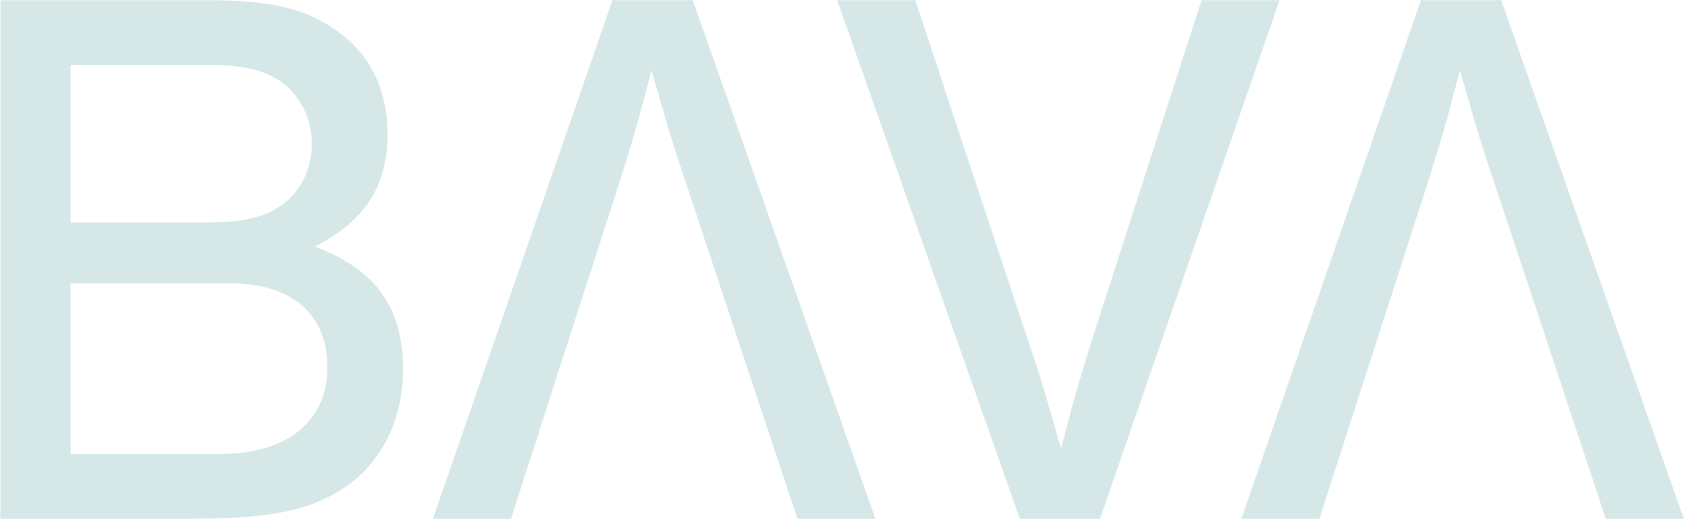
</div>

**API Validation & Prediction** <br>
This document will be validate the gathered API Data and will is able to being used for predictions and analyses

***Temperature Prediction*** <br>
To start off Machine Learning is being used to predict the temperature of the certain amount of days in the toilet. By using basic regression model (linear) its possible to predict the temperature based on the API data thats being generated by the device.

# Imports <br>
In the first stage of the notebook all imports should be made for running the code later on in the notebook

In [1]:
import urllib.request
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
import datetime

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

# Disable copy warn
pd.options.mode.chained_assignment = None  # default='warn'

2.7.0


# Fetching API <br>
First gather the API Data from the URL. After that print the first elements of the fetched data

In [2]:
with urllib.request.urlopen("https://us-central1-bava-solutions.cloudfunctions.net/getAllDeviceData") as url:
    data = json.loads(url.read().decode())

In [3]:
df = pd.DataFrame(data)
df.tail()
# df['timestamp'][0]

,tvoc_ppm,tvoc_co2,pressure,batterylevel,mac,occupied,waterlevel,altitude,hum,timestamp,temp
491,3,169,100294,100,4C:EB:D6:74:46:C4,False,100,89,45,"{'_seconds': 1638267950, '_nanoseconds': 30800...",19
492,1,153,100285,100,4C:EB:D6:74:46:C4,False,100,90,44,"{'_seconds': 1638268576, '_nanoseconds': 13000...",19
493,3,165,100332,100,4C:EB:D6:74:46:C4,False,100,86,45,"{'_seconds': 1638272021, '_nanoseconds': 21300...",18
494,0,147,100338,100,4C:EB:D6:74:46:C4,False,100,85,45,"{'_seconds': 1638272643, '_nanoseconds': 62800...",18
495,3,168,99000,100,4C:EB:D6:74:46:C4,False,100,202,47,"{'_seconds': 1638340123, '_nanoseconds': 82200...",20


# Plotting the data

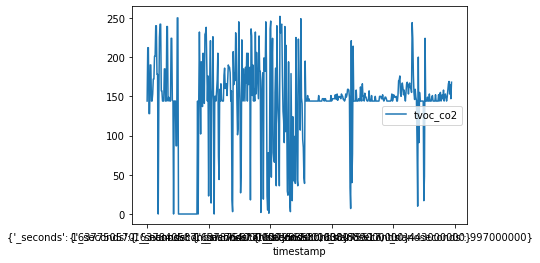

In [4]:
df.plot(x='timestamp', y='tvoc_co2')

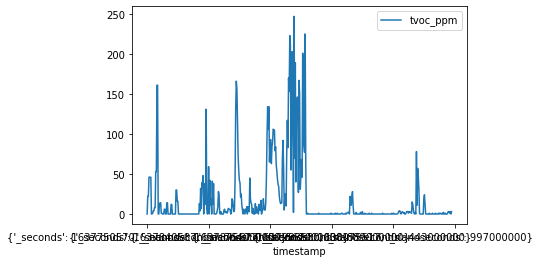

In [5]:
# Reading TVOC
df = pd.DataFrame(data)
df.plot(x='timestamp', y='tvoc_ppm')

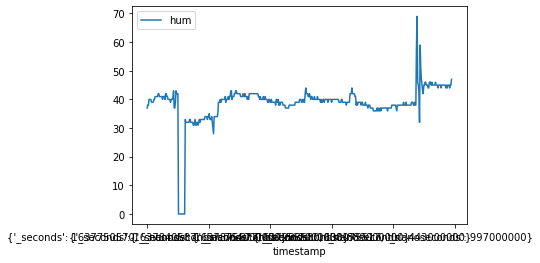

In [6]:
# Reading humidty
df.plot(x='timestamp', y='hum')

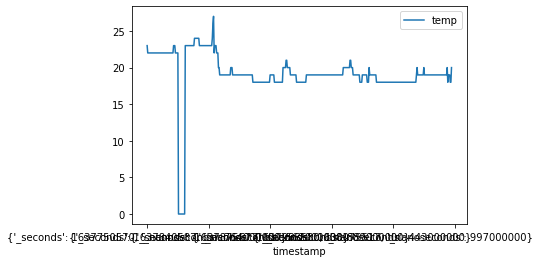

In [7]:
# Reading temperature
df.plot(x='timestamp', y='temp')

# The numbers mason <br>
The numbers mason what do they mean?

In [8]:
# Getting all triggers by occupation
triggerd_by_occupation = df[df['occupied']==1]
triggerd_by_occupation.count()['occupied']

46

In [9]:
# Getting all triggers by timer
triggerd_by_timer = df[df['occupied']==0]
triggerd_by_timer.count()['occupied']

450

# Predictions <br>
**Predictions based on Machine learning data**<br> 
First prediction is determining what the temperature might be in a few days.


In [10]:
# Tensorflow
np.set_printoptions(precision=3, suppress=True)

#Clean the data. Drop any columns with missing values or null values.

dropping timestamp and mac because they are categorical and irrelevant.

dropping batterylevel and waterlevel because they all have same data.

In [11]:
dataset = df.copy()
dataset.isna().sum()

dataset.dropna()
cleaned_dataset = dataset.drop(['mac', 'batterylevel', 'waterlevel', 'occupied'], axis=1)

temp = cleaned_dataset

for i in range(len(cleaned_dataset['timestamp'])):
  cleaned_dataset['timestamp'][i] = datetime.datetime.utcfromtimestamp((cleaned_dataset['timestamp'][i]['_seconds']) ).strftime('%Y-%m-%d')

cleaned_dataset.index = pd.to_datetime(cleaned_dataset['timestamp'])
cleaned_dataset = cleaned_dataset[cleaned_dataset['tvoc_ppm'] != 0]
cleaned_dataset = cleaned_dataset.drop(['timestamp'], axis=1)
cleaned_dataset


,tvoc_ppm,tvoc_co2,pressure,altitude,hum,temp
timestamp,,,,,,
2021-11-24,22,212,102241,-79,38,22
2021-11-24,22,212,102240,-78,38,22
2021-11-24,46,128,102221,-78,40,22
2021-11-24,46,128,102229,-77,40,22
2021-11-24,46,190,102216,-76,40,22
...,...,...,...,...,...,...
2021-11-30,3,166,100282,90,45,19
2021-11-30,3,169,100294,89,45,19
2021-11-30,1,153,100285,90,44,19


#Splitting for regression using Tensorflow

In [12]:

train_data = cleaned_dataset.sample(frac=0.5, random_state=0)

test_data = cleaned_dataset.sample(frac=0.2, random_state=0)

# test_data

# cleaned_dataset = cleaned_dataset.drop(['timestamp'], axis=1)

# train_data, test_data = np.split(cleaned_dataset, [int(.3 *len(data))])

train_data
print(len(test_data), len(train_data), len(cleaned_dataset))

# Y = cleaned_dataset['temp']
# x = cleaned_dataset.loc[:, cleaned_dataset.columns != 'temp']

52 130 259


#Split attributes and labels apart

In [13]:
train_features = cleaned_dataset.copy()
test_features = cleaned_dataset.copy()

train_labels = train_features.pop('temp')
test_labels = test_features.pop('temp')



train_labels

train_data = train_data.drop(['temp'], axis=1)
test_data = test_data.drop(['temp'], axis=1)

print(test_data)

# train_dataset_timeseries = keras.preprocessing.timeseries_dataset_from_array(train_data, train_labels, sequence_length=len(train_data))
# TimeSeries

            tvoc_ppm  tvoc_co2  pressure  altitude  hum
timestamp                                              
2021-11-30         1       153    100243        93   45
2021-11-25         3       170    100752        49   40
2021-11-28         3       167     99536       155   38
2021-11-25         5       182    100731        51   41
2021-11-25       134         1    100715        53   40
2021-11-26        83        24     98362       258   37
2021-11-24         4       172    102202       -75   40
2021-11-28        57        10     99653       145   46
2021-11-26        77        39     98232       269   39
2021-11-25        70       176    100592        63   39
2021-11-27         1       152     98475       248   39
2021-11-26       109        93     98345       260   38
2021-11-25        22        36    100624        61   39
2021-11-25        38       141    100986        29   33
2021-11-27        23        40     98741       225   44
2021-11-26       225       195     98239       2

In [14]:
train_stat = train_data.describe().transpose()[['mean', 'std']]
train_stat

,mean,std
tvoc_ppm,36.923077,51.808475
tvoc_co2,152.900000,62.009108
pressure,100220.923077,1250.890750
altitude,95.576923,109.370919
hum,39.876923,3.815544


#Normalization
***Normalizing is helpful to bound data between the range from 0 to 1***

In [15]:
def normalize(row):
  # t = row['timestamp']
  

  answer = (row - train_stat['mean']) / train_stat['std']
  print(row, answer)
  # answer['timestamp'] = t
  
  return answer

normed_train = normalize(train_data)
normed_test = normalize(test_data)

print(normed_test)



normed_train = np.asarray(normed_train).astype(np.float32)
normed_test = np.asarray(normed_test).astype(np.float32)

# normed_train
# normed_test
train_labels

            tvoc_ppm  tvoc_co2  pressure  altitude  hum
timestamp                                              
2021-11-30         1       153    100243        93   45
2021-11-25         3       170    100752        49   40
2021-11-28         3       167     99536       155   38
2021-11-25         5       182    100731        51   41
2021-11-25       134         1    100715        53   40
...              ...       ...       ...       ...  ...
2021-11-25        19        14    100961        31   33
2021-11-28         3       168     99535       155   38
2021-11-30         3       166    100282        90   45
2021-11-25        65        64    100712        53   40
2021-11-25         1       151    100812        44   40

[130 rows x 5 columns]             tvoc_ppm  tvoc_co2  pressure  altitude       hum
timestamp                                                   
2021-11-30 -0.693382  0.001613  0.017649 -0.023561  1.342686
2021-11-25 -0.654779  0.275766  0.424559 -0.425862  0.032257
2021

timestamp
2021-11-24    22
2021-11-24    22
2021-11-24    22
2021-11-24    22
2021-11-24    22
              ..
2021-11-30    19
2021-11-30    19
2021-11-30    19
2021-11-30    18
2021-12-01    20
Name: temp, Length: 259, dtype: int64

#Building the model using Tensorflow Keras

In [16]:
# For building the model using function for in the future its better to create multiple models
def create_model():
  model = keras.Sequential([
      layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_data.keys())]),
      layers.Dense(1)
  ])

  optimiser = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse', optimizer=optimiser, metrics=['mae', 'mse'])

  return model

In [17]:
model = create_model()

#Insights of the model

In [18]:
model.summary() # Overview of the created model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________


In [19]:
early_block = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)                                     # Add auto stop incase the loss is less enough.
full_model = model.fit(normed_train, train_labels, epochs=10000, validation_split=0.2, callbacks=[early_block])   # Actual model training

Epoch 1/10000
4/4 [==============================] - 1s 56ms/step - loss: 428.8806 - mae: 20.6179 - mse: 428.8806 - val_loss: 324.3737 - val_mae: 18.0026 - val_mse: 324.3737
Epoch 2/10000
4/4 [==============================] - 0s 7ms/step - loss: 421.5280 - mae: 20.4391 - mse: 421.5280 - val_loss: 319.7819 - val_mae: 17.8738 - val_mse: 319.7819
Epoch 3/10000
4/4 [==============================] - 0s 10ms/step - loss: 416.4637 - mae: 20.3137 - mse: 416.4637 - val_loss: 316.1600 - val_mae: 17.7715 - val_mse: 316.1600
Epoch 4/10000
4/4 [==============================] - 0s 13ms/step - loss: 412.0111 - mae: 20.2029 - mse: 412.0111 - val_loss: 312.6118 - val_mae: 17.6705 - val_mse: 312.6118
Epoch 5/10000
4/4 [==============================] - 0s 9ms/step - loss: 407.8630 - mae: 20.0991 - mse: 407.8630 - val_loss: 309.1645 - val_mae: 17.5718 - val_mse: 309.1645
Epoch 6/10000
4/4 [==============================] - 0s 8ms/step - loss: 403.7335 - mae: 19.9948 - mse: 403.7335 - val_loss: 306.131

# Model training validation
How well did the model trained? How is the loss?


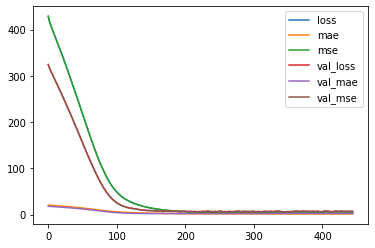

In [20]:
losses = pd.DataFrame(model.history.history)
losses.plot() # Plot the loss

## Model Testing


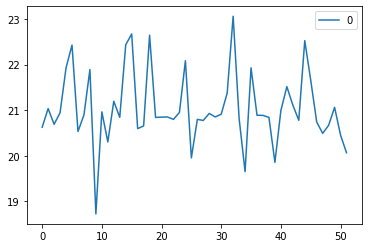

In [21]:
# Tesing the Model based on values from training X = Time , Y = Predicted temperature
testmodel = pd.DataFrame(model.predict(normed_test))
testmodel.plot()

In [22]:
# Predict what the temperature will be after x amount of days
howmany = 90 # 10 days
answer = model.predict([normed_test[0:(howmany % len(normed_test))]])
print(f"The temperature would be {answer.mean()} degrees after {howmany}")

The temperature would be 21.083337783813477 degrees after 90
